### Initial playground for domain adaptation and moving into active learning

* Paul Blankley 

In [25]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.active_learning as al

import importlib as imp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import pyro

%matplotlib inline

In [2]:
al = imp.reload(al)

In [3]:
######## SET PARAMS ##########
batch_size = 8
start_size = 64

##############################

# Get raw datasets 
train_set = dset.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=False)
test_set = dset.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Get loaders and initial indices
loaders, init_idx, unlab_idx = al.setup_data_loaders(batch_size=batch_size, starting_size=start_size,\
                                                     use_cuda=False)
train_loader, unlab_loader, val_loader, test_loader = loaders

In [4]:
# Get x/y split for the validation and test sets 
test_x,test_y = al.get_xy_split(test_loader)


### Idea:

You start with 64 random points to make a model. Then you get to choose 16 points to have the labels given to you.  Just pass a policy function that decides which policy to follow to get the new points.  Then compare the two policies and show that the "active learning" (with intelligent policy performs better).

In [56]:
def get_dataset_split(train_set, other_size=10000, random_seed=1992):
    np.random.seed(random_seed)
    if isinstance(train_set, tuple):
#         print(train_set[0].size(),train_set[0][0].size())
        msk = np.random.choice(range(len(train_set[1])),size=other_size, replace=False)
        x1_tensor = torch.cat([train_set[0][i].view(-1,28,28) for i in msk])
        y1_tensor = torch.LongTensor([train_set[1][i] for i in msk])
        x2_tensor = torch.cat([train_set[0][i].view(-1,28,28) for i in range(len(train_set[1])) if i not in msk])
        y2_tensor = torch.LongTensor([train_set[1][i] for i in range(len(train_set[1])) if i not in msk])
    else:
        msk = np.random.choice(range(len(train_set)),size=other_size, replace=False)
        x1_tensor = torch.cat([train_set[i][0] for i in msk])
        y1_tensor = torch.LongTensor([train_set[i][1] for i in msk])
        x2_tensor = torch.cat([train_set[i][0] for i in range(len(train_set)) if i not in msk])
        y2_tensor = torch.LongTensor([train_set[i][1] for i in range(len(train_set)) if i not in msk])
    return x2_tensor, y2_tensor, x1_tensor, y1_tensor


    
# get_uniform_split(train_x,train_y, 12)
# train_x, train_y, val_x, val_y = get_dataset_split(train_set)

In [43]:
# Define the model
class logreg(nn.Module):
    """ Logistic regression """
    def __init__(self, classes):
        super(logreg, self).__init__()
        self.classes = classes
        self.w = nn.Linear(28*28,classes)
        
    def forward(self, x):
        x = self.w(x.view(-1,1,28*28))
        return F.log_softmax(x.view(-1,self.classes),dim=1)

class CNN(nn.Module):
    """ CNN for MNIST """
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
#         print(x.size())
        x = x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)
     

In [65]:
model = logreg(classes=10)
cnn = CNN()
loss_func = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)

def train_(model, train_x, train_y, loss_func, optimizer, epochs=10, batch_size=8):
    losses,itrs = [],0
    tensor_dataset = torch.utils.data.dataset.TensorDataset(train_x,train_y)
    tr_loader = torch.utils.data.DataLoader(dataset=tensor_dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        for i,(batch_x,batch_y) in enumerate(tr_loader):
            batch_x = Variable(batch_x)
            batch_y = Variable(batch_y)

            y_pred = model(batch_x)
            loss = loss_func(y_pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itrs+=1
            losses.append(loss.data.numpy()[0])

    return list(range(itrs)), losses

def active_learn(model, train_x, train_y, policy, loss_func, optimizer, val_x, val_y, \
                 epochs_per_train=10, npoints=16, batch_size=8, meta_epochs=10, random_seed=832):
    """ Active learning based on a specified policy. """
    # initialy train the model and then based on unlabeled results use the policy to choose more points ans iterate
    total_acc = []
    unlab_x,unlab_y,lab_x,lab_y = get_uniform_split(train_x,train_y, n=npoints, random_seed=random_seed)

    for e in range(meta_epochs):
        # Train the model
        itr, losses = train_(model, lab_x, lab_y, loss_func, optimizer, epochs=epochs_per_train, \
                             batch_size=batch_size)
        
        # Get the next points to label 
        unlab_x,unlab_y, addtl_x, addtl_y = get_req_points(model, unlab_x, unlab_y, policy=policy, n=16)
#         print('labs of addtl y',addtl_y.numpy())
#         print('lookie here',torch.exp(model(Variable(addtl_x))))
        lab_x, lab_y = torch.cat([lab_x, addtl_x]), torch.cat([lab_y, addtl_y])
 
        # Get accuracy of the model 
        total_acc.append(al.accuracy(model,val_x,val_y))
        
    return list(range(meta_epochs)), total_acc


def get_req_points(model, unlab_x, unlab_y, policy='random', n=16, random_seed=13):
    if policy!='random':
        pred_y = model.forward(Variable(unlab_x))
        if policy=='boundary':
            fn = boundary_policy
        elif policy=='uniform':
            fn = uniform_policy
        elif policy=='max_entropy':
            fn = max_entropy_policy
        elif policy=='conf':
            fn = least_confidence_policy
        idxs = fn(pred_y, n=n)
        new_u_x, new_u_y, add_x, add_y = get_idx_split(unlab_x, unlab_y, idxs)
    else: 
        new_u_x, new_u_y, add_x, add_y = get_dataset_split((unlab_x,unlab_y), other_size=n, random_seed=random_seed)
    return new_u_x, new_u_y, add_x, add_y

def boundary_policy(pred_y, n):
    result = al.boundary_proximity(pred_y, num_points=n)
    return result

def get_idx_split(data_x, data_y, idx):
    x1_tensor = torch.cat([data_x[i].view(-1,28,28) for i in idx])
    y1_tensor = torch.LongTensor([data_y[i] for i in idx])
    x2_tensor = torch.cat([data_x[i].view(-1,28,28) for i in range(len(data_y)) if i not in idx])
    y2_tensor = torch.LongTensor([data_y[i] for i in range(len(data_y)) if i not in idx])
    return x2_tensor, y2_tensor, x1_tensor, y1_tensor

def get_uniform_split(train_x, train_y, n, random_seed=1823):
    np.random.seed(random_seed)
    cut = n%10
    times = n//10
    output = []
    for res in range(10): # number of classes
        y_idx = [idx for idx, elm in enumerate(train_y) if elm == res]
        if res<cut:
            output.extend(np.random.choice(y_idx, size=times+1))
        else:
            output.extend(np.random.choice(y_idx, size=times))
    return get_idx_split(train_x, train_y, output)

def max_entropy_policy(pred_y, n):
    """ Source of math: https://www.cs.cmu.edu/~tom/10701_sp11/recitations/Recitation_13.pdf """
    probs = torch.exp(pred_y.data)
    prob_logprob = probs*pred_y.data
    max_ent = -torch.sum(prob_logprob, dim=1)
    max_ent_idxs = al.n_argmax(max_ent, size=n)
    return max_ent_idxs

def least_confidence_policy(pred_y, n):
    maxes = torch.max(pred_y.data,1)[0]
    least_conf = 1.0-maxes
    least_conf_idx = al.n_argmax(least_conf, size=n)
    return least_conf_idx

def uniform_policy(pred_y, n):
    cut = n%10
    times = n//10
    _,preds = torch.max(pred_y,dim=1)
    output = []
    for res in range(10): # number of classes
        pred_idx = [idx for idx, elm in enumerate(preds) if elm.data.numpy()[0] == res]
        if len(pred_idx) < (times+1):
            if res<cut:
                output.extend(np.random.choice(range(len(preds)),size=times+1))
            else:
                output.extend(np.random.choice(range(len(preds)),size=times))
            continue
        if res<cut:
            output.extend(np.random.choice(pred_idx, size=times+1))
        else:
            output.extend(np.random.choice(pred_idx, size=times))
    return np.array(output)
    
# itr, acc = train_(model,train_x,train_y)
# itr, acc = train_(model,train_x[:16],train_y[:16],loss_func, optimizer)
# res = get_req_points(model, train_x, train_y, policy='max_entropy', n=16)
rrr = get_req_points(model, train_x, train_y, policy='conf', n=16)
# it, ac = active_learn(model, train_x, train_y, 'boundary', loss_func, optimizer, val_x, val_y, \
#                  epochs_per_train=10, npoints=16, batch_size=8, meta_epochs=10)
# plt.plot(it,ac)
print('test_acc',al.accuracy(model,test_x,test_y))

test_acc 0.0849


In [8]:
def plot_al_results(meta_epochs, accs, labs): 
    itrs = np.array(list(range(meta_epochs)))
    means, errs = [], []
    for ac in accs:
        means.append(np.mean(ac, axis=0))
        errs.append(np.std(ac,axis=0))

    plt.figure(figsize=(8,8))
    for ac_mean, ac_err, ac_lab in zip(means, errs, labs):
        plt.plot(itrs, ac_mean, label=ac_lab)
        plt.fill_between(itrs, ac_mean+ac_err, ac_mean-ac_err, alpha=0.4)

    plt.title('Accuracy of various active learning policies.')
    plt.xlabel('Meta Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    sns.despine()

In [63]:
########### GLOBAL EXPERIMENT PARAMS ############
# Epochs of adding additional points
meta_epochs = 300
# Epochs per training run
ept = 10
# Number of points to start with and add each run 
npoints = 20
batch_size = 8
learning_rate = 0.01
# Number of runs to create a sampling distribution to quantify error 
samp_runs = 5

#################################################

def try_policy(policy, meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs):
    # general policy test 
    try_acc = []
    for i in tqdm(range(samp_runs)):
        model_try = logreg(classes=10)
#         model_try = CNN()
        optimizer_try = optim.SGD(model_try.parameters(), lr=learning_rate)
        _, val_acc = active_learn(model_try, train_x, train_y, policy, loss_func, optimizer_try, \
                                            val_x, val_y, epochs_per_train=ept, npoints=npoints, \
                                            batch_size=batch_size, meta_epochs=meta_epochs)
        try_acc.append(val_acc)
    print(f'Active Learning with {policy} policy done!')
    return try_acc


random_acc = try_policy('random', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
boundary_acc = try_policy('boundary', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
entropy_acc = try_policy('max_entropy', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
confidence_acc = try_policy('conf', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
# uniform_acc = try_policy('uniform', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)

A Jupyter Widget


Active Learning with random policy done!


A Jupyter Widget


Active Learning with boundary policy done!


A Jupyter Widget

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log2



Active Learning with max_entropy policy done!


A Jupyter Widget


Active Learning with conf policy done!


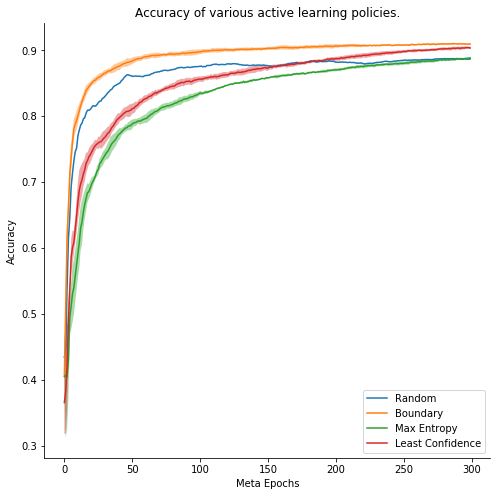

In [64]:
accs = [random_acc,boundary_acc,entropy_acc, confidence_acc]#,uniform_acc]
labs = ['Random','Boundary','Max Entropy', 'Least Confidence']#,'Uniform']
plot_al_results(meta_epochs,accs,labs)

In [ ]:
# add cluster policy?
# get max entropy and least confidence working

In [237]:
# print(torch.sum(torch.exp(model_bound(Variable(test_x))),dim=1))
# print(torch.sum(nn.functional.softmax(model_bound(Variable(test_x)),dim=1),dim=1))
# print(torch.sum(nn.functional.softmax(nn.functional.softmax(model_bound(Variable(test_x)),dim=1),dim=1),dim=1))
print(torch.exp(model(Variable(test_x)))[0])
sft = nn.functional.softmax(model(Variable(test_x)),dim=1)
print(sft[0])
print(nn.functional.softmax(sft,dim=1)[0])

Variable containing:
 0.0014
 0.0000
 0.0004
 0.0018
 0.0008
 0.0017
 0.0001
 0.9858
 0.0014
 0.0067
[torch.FloatTensor of size 10]

Variable containing:
 0.0014
 0.0000
 0.0004
 0.0018
 0.0008
 0.0017
 0.0001
 0.9858
 0.0014
 0.0067
[torch.FloatTensor of size 10]

Variable containing:
 0.0856
 0.0855
 0.0855
 0.0857
 0.0856
 0.0857
 0.0855
 0.2292
 0.0856
 0.0861
[torch.FloatTensor of size 10]



In [10]:
from __future__ import print_function
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad, Adam
from keras.utils import np_utils, generic_utils
from six.moves import range
import numpy as np
import scipy as sp
from keras import backend as K  
import random
import scipy.io
import matplotlib.pyplot as plt
from keras.regularizers import l2


Experiments = 3

batch_size = 128
nb_classes = 10

#use a large number of epochs
nb_epoch = 50

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3


score=0
all_accuracy = 0
acquisition_iterations = 98

#use a large number of dropout iterations
Queries = 10


Experiments_All_Accuracy = np.zeros(shape=(acquisition_iterations+1))



for e in range(Experiments):

	print('Experiment Number ', e)

	# the data, shuffled and split between tran and test sets
	(X_train_All, y_train_All), (X_test, y_test) = mnist.load_data()

	X_train_All = X_train_All.reshape(X_train_All.shape[0], 1, img_rows, img_cols)
	X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)

	random_split = np.asarray(random.sample(range(0,X_train_All.shape[0]), X_train_All.shape[0]))

	X_train_All = X_train_All[random_split, :, :, :]
	y_train_All = y_train_All[random_split]

	X_valid = X_train_All[10000:15000, :, :, :]
	y_valid = y_train_All[10000:15000]

	X_Pool = X_train_All[20000:60000, :, :, :]
	y_Pool = y_train_All[20000:60000]


	X_train_All = X_train_All[0:10000, :, :, :]
	y_train_All = y_train_All[0:10000]

	#training data to have equal distribution of classes
	idx_0 = np.array( np.where(y_train_All==0)  ).T
	idx_0 = idx_0[0:10,0]
	X_0 = X_train_All[idx_0, :, :, :]
	y_0 = y_train_All[idx_0]

	idx_0 = np.array( np.where(y_train_All==0)  ).T
	idx_0 = idx_0[0:2,0]
	X_0 = X_train_All[idx_0, :, :, :]
	y_0 = y_train_All[idx_0]

	idx_1 = np.array( np.where(y_train_All==1)  ).T
	idx_1 = idx_1[0:2,0]
	X_1 = X_train_All[idx_1, :, :, :]
	y_1 = y_train_All[idx_1]

	idx_2 = np.array( np.where(y_train_All==2)  ).T
	idx_2 = idx_2[0:2,0]
	X_2 = X_train_All[idx_2, :, :, :]
	y_2 = y_train_All[idx_2]

	idx_3 = np.array( np.where(y_train_All==3)  ).T
	idx_3 = idx_3[0:2,0]
	X_3 = X_train_All[idx_3, :, :, :]
	y_3 = y_train_All[idx_3]

	idx_4 = np.array( np.where(y_train_All==4)  ).T
	idx_4 = idx_4[0:2,0]
	X_4 = X_train_All[idx_4, :, :, :]
	y_4 = y_train_All[idx_4]

	idx_5 = np.array( np.where(y_train_All==5)  ).T
	idx_5 = idx_5[0:2,0]
	X_5 = X_train_All[idx_5, :, :, :]
	y_5 = y_train_All[idx_5]

	idx_6 = np.array( np.where(y_train_All==6)  ).T
	idx_6 = idx_6[0:2,0]
	X_6 = X_train_All[idx_6, :, :, :]
	y_6 = y_train_All[idx_6]

	idx_7 = np.array( np.where(y_train_All==7)  ).T
	idx_7 = idx_7[0:2,0]
	X_7 = X_train_All[idx_7, :, :, :]
	y_7 = y_train_All[idx_7]

	idx_8 = np.array( np.where(y_train_All==8)  ).T
	idx_8 = idx_8[0:2,0]
	X_8 = X_train_All[idx_8, :, :, :]
	y_8 = y_train_All[idx_8]

	idx_9 = np.array( np.where(y_train_All==9)  ).T
	idx_9 = idx_9[0:2,0]
	X_9 = X_train_All[idx_9, :, :, :]
	y_9 = y_train_All[idx_9]

	X_train = np.concatenate((X_0, X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9), axis=0 )
	y_train = np.concatenate((y_0, y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9), axis=0 )


	print('X_train shape:', X_train.shape)
	print(X_train.shape[0], 'train samples')

	print('Distribution of Training Classes:', np.bincount(y_train))


	X_train = X_train.astype('float32')
	X_test = X_test.astype('float32')
	X_valid = X_valid.astype('float32')
	X_Pool = X_Pool.astype('float32')
	X_train /= 255
	X_valid /= 255
	X_Pool /= 255
	X_test /= 255

	Y_test = np_utils.to_categorical(y_test, nb_classes)
	Y_valid = np_utils.to_categorical(y_valid, nb_classes)
	Y_Pool = np_utils.to_categorical(y_Pool, nb_classes)


	#loss values in each experiment
	Pool_Valid_Loss = np.zeros(shape=(nb_epoch, 1)) 	
	Pool_Train_Loss = np.zeros(shape=(nb_epoch, 1)) 
	Pool_Valid_Acc = np.zeros(shape=(nb_epoch, 1)) 	
	Pool_Train_Acc = np.zeros(shape=(nb_epoch, 1)) 
	x_pool_All = np.zeros(shape=(1))

	Y_train = np_utils.to_categorical(y_train, nb_classes)

	print('Training Model Without Acquisitions in Experiment', e)


	model = Sequential()
	model.add(Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='valid', input_shape=(1, img_rows, img_cols)))
	model.add(Activation('relu'))
	model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
	model.add(Activation('relu'))
	model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
	model.add(Dropout(0.25))
	
	model.add(Convolution2D(nb_filters*2, nb_conv, nb_conv, border_mode='valid', input_shape=(1, img_rows, img_cols)))
	model.add(Activation('relu'))
	model.add(Convolution2D(nb_filters*2, nb_conv, nb_conv))
	model.add(Activation('relu'))
	model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
	model.add(Dropout(0.25))

	c = 3.5
	Weight_Decay = c / float(X_train.shape[0])
	model.add(Flatten())
	model.add(Dense(128, W_regularizer=l2(Weight_Decay)))
	model.add(Activation('relu'))
	model.add(Dropout(0.5))
	model.add(Dense(nb_classes))
	model.add(Activation('softmax'))


	model.compile(loss='categorical_crossentropy', optimizer='adam')
	hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=1, validation_data=(X_valid, Y_valid))
	Train_Result_Optimizer = hist.history
	Train_Loss = np.asarray(Train_Result_Optimizer.get('loss'))
	Train_Loss = np.array([Train_Loss]).T
	Valid_Loss = np.asarray(Train_Result_Optimizer.get('val_loss'))
	Valid_Loss = np.asarray([Valid_Loss]).T
	Train_Acc = np.asarray(Train_Result_Optimizer.get('acc'))
	Train_Acc = np.array([Train_Acc]).T
	Valid_Acc = np.asarray(Train_Result_Optimizer.get('val_acc'))
	Valid_Acc = np.asarray([Valid_Acc]).T


	Pool_Train_Loss = Train_Loss
	Pool_Valid_Loss = Valid_Loss
	Pool_Train_Acc = Train_Acc
	Pool_Valid_Acc = Valid_Acc


	Pool_Train_Loss = Train_Loss
	Pool_Valid_Loss = Valid_Loss

	print('Evaluating Test Accuracy Without Acquisition')
	score, acc = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)

	all_accuracy = acc

	print('Starting Active Learning in Experiment ', e)




	for i in range(acquisition_iterations):
		print('POOLING ITERATION', i)

		print('Using trained model for Entropy Calculation')

		Class_Probability = model.predict_proba(X_Pool, batch_size=batch_size, verbose=1)
		Class_Log_Probability = np.log2(Class_Probability)
		Entropy_Each_Cell = - np.multiply(Class_Probability, Class_Log_Probability)

		Entropy = np.sum(Entropy_Each_Cell, axis=1)	# summing across rows of the array

		#x_pool_index = 	np.unravel_index(Entropy.argmax(), Entropy.shape)	#for finding the maximum value np.amax(Entropy)
		a_1d = Entropy.flatten()
		x_pool_index = Entropy.argsort()[-Queries:][::-1]

		# THIS FINDS THE INDEX OF THE MINIMUM
		# a_1d = Entropy.flatten()
		# x_pool_index = a_1d.argsort()[-N:]

		#saving pooled images
		# for im in range(x_pool_index[0:2].shape[0]):
		# 	Image = X_Pool[x_pool_index[im], :, :, :]
		# 	img = Image.reshape((28,28))
		# 	sp.misc.imsave('/home/ri258/Documents/Project/Active-Learning-Deep-Convolutional-Neural-Networks/ConvNets/Cluster_Experiments/Max_Entropy/Pooled_Images/' + 'Experiment_' + str(e) +'Pool_Iter'+str(i)+'_Image_'+str(im)+'.jpg', img)

		#store all the pooled images indexes
		x_pool_All = np.append(x_pool_All, x_pool_index)


		Pooled_X = X_Pool[x_pool_index, :, :, :]
		Pooled_Y = y_Pool[x_pool_index]		# true label from the oracle

		print('Acquised Points added to training set')
		X_train = np.concatenate((X_train, Pooled_X), axis=0)
		y_train = np.concatenate((y_train, Pooled_Y), axis=0)

		#delete the currently pooled points from the pool set
		# X_Pool = np.delete(X_Pool, x_pool_index, 0)
		# y_Pool = np.delete(y_Pool, x_pool_index)

		X_Pool = np.delete(X_Pool, (x_pool_index), axis=0)
		y_Pool = np.delete(y_Pool, (x_pool_index), axis=0)
		

		print('Training Model with pooled points')

		# convert class vectors to binary class matrices
		Y_train = np_utils.to_categorical(y_train, nb_classes)


		model = Sequential()
		model.add(Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='valid', input_shape=(1, img_rows, img_cols)))
		model.add(Activation('relu'))
		model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
		model.add(Activation('relu'))
		model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
		model.add(Dropout(0.25))


		c = 3.5
		Weight_Decay = c / float(X_train.shape[0])
		model.add(Flatten())
		model.add(Dense(128, W_regularizer=l2(Weight_Decay)))
		model.add(Activation('relu'))
		model.add(Dropout(0.5))
		model.add(Dense(nb_classes))
		model.add(Activation('softmax'))

		model.compile(loss='categorical_crossentropy', optimizer='adam')
		hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=1, validation_data=(X_valid, Y_valid))
		Train_Result_Optimizer = hist.history
		Train_Loss = np.asarray(Train_Result_Optimizer.get('loss'))
		Train_Loss = np.array([Train_Loss]).T
		Valid_Loss = np.asarray(Train_Result_Optimizer.get('val_loss'))
		Valid_Loss = np.asarray([Valid_Loss]).T
		Train_Acc = np.asarray(Train_Result_Optimizer.get('acc'))
		Train_Acc = np.array([Train_Acc]).T
		Valid_Acc = np.asarray(Train_Result_Optimizer.get('val_acc'))
		Valid_Acc = np.asarray([Valid_Acc]).T

		#Accumulate the training and validation/test loss after every pooling iteration - for plotting
		Pool_Valid_Loss = np.append(Pool_Valid_Loss, Valid_Loss, axis=1)
		Pool_Train_Loss = np.append(Pool_Train_Loss, Train_Loss, axis=1)
		Pool_Valid_Acc = np.append(Pool_Valid_Acc, Valid_Acc, axis=1)
		Pool_Train_Acc = np.append(Pool_Train_Acc, Train_Acc, axis=1)	

		print('Evaluate Model Test Accuracy with pooled points')

		score, acc = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)
		print('Test score:', score)
		print('Test accuracy:', acc)
		all_accuracy = np.append(all_accuracy, acc)


		print('Use this trained model with pooled points for Dropout again')

	print('Storing Accuracy Values over experiments')
	Experiments_All_Accuracy = Experiments_All_Accuracy + all_accuracy



	print('Saving Results Per Experiment')
# 	np.save('/home/ri258/Documents/Project/MPhil_Thesis_Cluster_Experiments/ConvNets/Cluster_Experiments/Final_Experiments/Results/'+'Max_Entropy_Q10_N1000_Train_Loss_'+ 'Experiment_' + str(e) + '.npy', Pool_Train_Loss)
# 	np.save('/home/ri258/Documents/Project/MPhil_Thesis_Cluster_Experiments/ConvNets/Cluster_Experiments/Final_Experiments/Results/'+ 'Max_Entropy_Q10_N1000_Valid_Loss_'+ 'Experiment_' + str(e) + '.npy', Pool_Valid_Loss)
# 	np.save('/home/ri258/Documents/Project/MPhil_Thesis_Cluster_Experiments/ConvNets/Cluster_Experiments/Final_Experiments/Results/'+'Max_Entropy_Q10_N1000_Train_Acc_'+ 'Experiment_' + str(e) + '.npy', Pool_Train_Acc)
# 	np.save('/home/ri258/Documents/Project/MPhil_Thesis_Cluster_Experiments/ConvNets/Cluster_Experiments/Final_Experiments/Results/'+ 'Max_Entropy_Q10_N1000_Valid_Acc_'+ 'Experiment_' + str(e) + '.npy', Pool_Valid_Acc)
# 	np.save('/home/ri258/Documents/Project/MPhil_Thesis_Cluster_Experiments/ConvNets/Cluster_Experiments/Final_Experiments/Results/'+'Max_Entropy_Q10_N1000_Pooled_Image_Index_'+ 'Experiment_' + str(e) + '.npy', x_pool_All)
# 	np.save('/home/ri258/Documents/Project/MPhil_Thesis_Cluster_Experiments/ConvNets/Cluster_Experiments/Final_Experiments/Results/'+ 'Max_Entropy_Q10_N1000_Accuracy_Results_'+ 'Experiment_' + str(e) + '.npy', all_accuracy)

print('Saving Average Accuracy Over Experiments')

Average_Accuracy = np.divide(Experiments_All_Accuracy, Experiments)

# np.save('/home/ri258/Documents/Project/MPhil_Thesis_Cluster_Experiments/ConvNets/Cluster_Experiments/Final_Experiments/Results/'+'Max_Entropy_Q10_N1000_Average_Accuracy'+'.npy', Average_Accuracy)


Experiment Number  0
11493376/11490434 [==============================] - 1s 0us/step
X_train shape: (20, 1, 28, 28)
20 train samples
Distribution of Training Classes: [2 2 2 2 2 2 2 2 2 2]
Training Model Without Acquisitions in Experiment 0


/Users/paulblankley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:167: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(1, 28, 28..., padding="valid")`


ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_1/convolution' (op: 'Conv2D') with input shapes: [?,1,28,28], [3,3,28,32].

### Results with 2/27/18 version of max entropy policy 

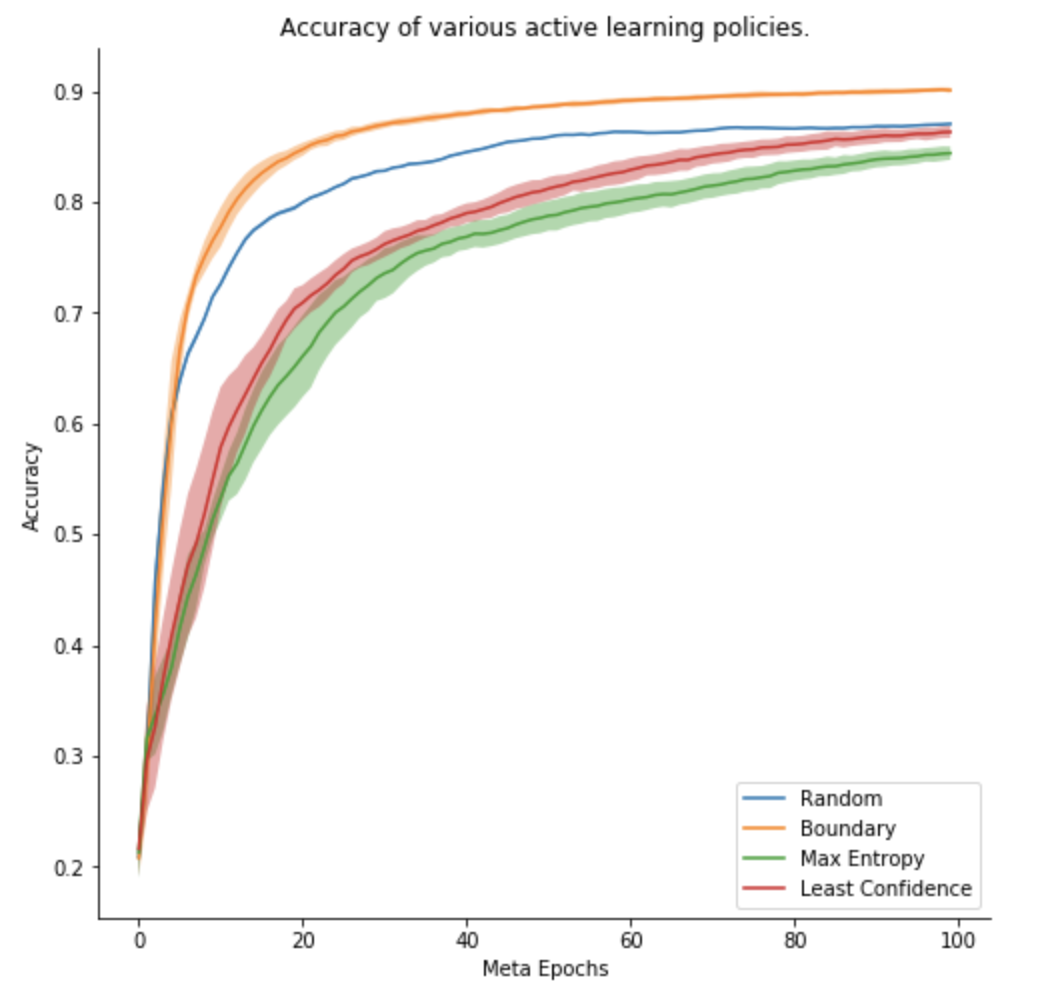